In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:

def word_to_action(word, guesses, history):
    return dfword_to_action((word, df.loc[word]), guesses, history)
    
def dfword_to_action(dfword, guesses, history):
    #the action is going to be a word that we will submit next
    #for the purposes of feeding into the model, we will represent the action word as:
    #  how many of the entries in the hint history this word conforms to
    #  how many untried letters it gives us
    #  the number of uniq letters in the word
    #  the frequency of the letters in the word
    #  whether or not the word is in the guess list (as opposed to the target list)
    word = dfword[0]
    dfword = dfword[1]
    
    if guesses:
        conforms_to_history = sum([int(validate_against_hint(word,g,history[i])) for i,g in enumerate(guesses)]) / len(guesses)
    else: # we haven't made any guess yet, so this must conform
        conforms_to_history = 1.0
    num_untried_letters = len(set(word) - set(''.join(guesses))) / 5 #normalise to 1
    action = np.array([conforms_to_history, num_untried_letters, dfword['freq_score'], dfword['uniq_score'], dfword['is_guess_word']])
    
    #if word == 'aargh':
    #    print(f'recons', action, history, guesses)
    return action   
    

def construct_action_vectors_global(arg): #guesses, history, start_idx, end_idx):
    st = time.time()
    guesses, history, start_idx, end_idx = arg
    #print(guesses, history, start_idx, end_idx)
    ret = np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iloc[start_idx:end_idx].iterrows()])
    #print(f'construct_actions_global took {time.time() - st}')
    return ret
           
def construct_action_vectors(guesses, history, df):
        return np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iterrows()])
    
NUM_PROCESSES = mp.cpu_count() - 1
def construct_action_vectors_mp(guesses, history, df):
        grp_lst_args = []
        grp_guesses = [guesses] * NUM_PROCESSES
        grp_history = [history] * NUM_PROCESSES
        
        chunk_size = int(len(df) / NUM_PROCESSES) + 1
        start_offsets = list(range(0, len(df), chunk_size))
        end_offsets = start_offsets[1:] + [len(df)]
        grp_lst_args = list(zip(grp_guesses, grp_history, start_offsets, end_offsets))
        
        #print(grp_lst_args)
        pool = mp.Pool(processes=NUM_PROCESSES)
        results = pool.map(construct_action_vectors_global, grp_lst_args)
        pool.close()
        pool.join()
        return np.concatenate(results)
    
    
def construct_state_vector(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        return np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))


    

   
so the state is going to be:
* The number of green locations we know
*  The number of other letters we know to be in the word
*  The number of letters we know to not be in the word
*  The sequence number of the guess (1st guess, 2nd guess etc.)

the action is going to be a word that we will submit next
for the purposes of feeding into the model, we will represent the action word as:
*  whether or not it conforms to the hint history
*  how many new letters it gives us
*  the number of uniq letters in the word
*  the frequency of the letters in the word

the reward is going to be:
*  the score improvement (if any) gained on the last guess
*  the score will be calculated as 2 * num_green_letters + num_orange_letters

In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
#Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5
n_state_features = 9
n_input_features = n_action_features + n_state_features


def select_action(policy_net, state, actions, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            #now combine the state (shape 3,) and action (shape 5, n) into one input array (shape 8,n)
            #first expand the state so that it is shape 3,1
            #then repeat it to 3,n
            states = np.repeat(np.expand_dims(state, 0), actions.shape[0], axis=0)
            #print(f'states shape {states.shape} actions shape {actions.shape}')
            #then concatenate to 8,n
            state_actions = np.concatenate((states, actions), axis=1)
            # policy_net(state_action) will return a single value estimate for each state/action row
            # so, probably shape (1,n)
            # Then return the index which has the max value
            
            estimate = policy_net(torch.tensor(state_actions, device=device, dtype=torch.float))
            #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
            return estimate.max(0).indices.item()
    else:
        randindex = random.randrange(len(actions))
        print(f'returning random index {randindex}')
        return randindex #torch.tensor([[randindex]], device=device, dtype=torch.long)



def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [7]:
class DQN(nn.Module):

    def __init__(self, inputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 20)
        self.fc2 = nn.Linear(20, 16)
        self.fc3 = nn.Linear(16, 20)
        self.head = nn.Linear(20, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.head(x)

In [8]:
class LinearQ(nn.Module):

    def __init__(self, inputs):
        super(LinearQ, self).__init__()
        self.head = nn.Linear(inputs, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return self.head(x)

In [9]:
def optimize_model(model, optimizer, memory, batch_size=128):

    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    state_batch = np.stack([tr.state for tr in transitions])
    action_batch = np.stack([tr.action for tr in transitions])
      
    reward_batch = np.stack([tr.reward for tr in transitions])
    state_action_batch = np.concatenate((state_batch, action_batch), axis=1)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_value_estimates = model(torch.tensor(state_action_batch, device=device, dtype=torch.float))
    #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
       
    expected_state_action_values = torch.tensor(reward_batch, device=device, dtype=torch.float)
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_value_estimates, expected_state_action_values)
    
    print(f'loss {loss}')

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    #for param in model.parameters():
        #param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss

class TrainConfig():
    def __init__(self, train_interval=128, batch_size=128, clear_memory=False, lr=0.01):
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [12]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(clear_memory=False, batch_size=128, train_interval=128)):
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    EPS_START = eps[0]
    EPS_END = eps[1]
    EPS_DECAY = eps[2]
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_actions = construct_action_vectors(env.guesses, env.history, env.df)
    starting_state = construct_state_vector(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    if model.name == 'linear':
        policy_net = LinearQ(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    else:
        policy_net = DQN(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)

    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        actions = starting_actions
        guesses = []
        for t in count():
            eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            
            epsilons.append(eps)
            #print(epsilons)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            action_idx = select_action(policy_net, state, actions, eps)
            selected_action = actions[action_idx]
            guesses.append(env.word_from_index(action_idx))
            print(f'------guess {t} {action_idx} {guesses[-1]} {selected_action}-------')
            history, reward, done = env.step_by_index(action_idx)
            #here next_state == env.history
            if not done:
                next_state = construct_state_vector(guesses, history)
                actions = construct_action_vectors_mp(guesses, history, env.df)
            
            print(f'reward {reward} done {done} ')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, selected_action, reward)
            episode_memory.append([state, selected_action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                scores = history.sum(axis=1) # calc the score for each guess from the history
                episode_reward = sum(tr[2] for tr in episode_memory)
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                # reward[i] = max(0, scores[i] - max(scores[0:i-1]))
                
                for i,tr in enumerate(episode_memory):
                    if i == 0:
                        score = scores[i]
                    else:
                        score = max(0, scores[i] - scores[0:i].max())
                    print(f'{guesses[i]} {history[i]} {score}')    
                
                    memory.push(tr[0], tr[1], score)
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= training.batch_size \
                    and steps_done - last_training > training.train_interval:
                    loss = optimize_model(policy_net, optimizer, memory, batch_size=training.batch_size)
                    losses.append(loss)
                    if training.clear_memory: memory.clear()
                    last_training = steps_done
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward -1.0 done False 
------guess 2 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 3 12189 whiny [0.66666667 0.         0.3476069  0.         0.        ]-------
reward -1.0 done False 
------guess 4 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 5 12189 whiny [0.6       0.        0.3476069 0.        0.       ]-------
reward -1.0 done Tr

reward -1.0 done False 
------guess 2 12189 whiny [0.5       0.        0.3476069 0.        0.       ]-------
reward -1.0 done False 
------guess 3 11618 imply [0.66666667 0.2        0.39606902 0.         0.        ]-------
reward -1.0 done False 
------guess 4 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward -1.0 done False 
------guess 5 12722 girly [0.8        0.         0.45029257 0.         0.        ]-------
reward -1.0 done True 
episode 8 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 54  memory 48
jumpy [0. 0. 0. 0. 2.] 2.0
whiny [0. 0. 1. 0. 2.] 1.0
whiny [0. 0. 1. 0. 2.] 0
imply [1. 0. 0. 2. 2.] 2.0
girly [0. 2. 0. 2. 2.] 1.0
girly [0. 2. 0. 2. 2.] 0
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 1 11260 quick [1.         0.8        0.29752438 0.         0.        ]-------
reward -1.0 done False 
---

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 11271 spilt [1.         0.8        0.57341335 0.         0.        ]-------
reward -1.0 done False 
------guess 2 10837 using [1.         0.6        0.52606152 0.         0.        ]-------
reward 0.0 done True 
episode 11 finished.  reward -2.0  eps 0.0  gamma 0.0  steps 69  memory 66
arose [0. 0. 0. 1. 0.] 1.0
spilt [1. 0. 2. 0. 0.] 2.0
using [2. 2. 2. 2. 2.] 7.0
=========================episode 12 piece======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 11753 utile [1.         0.8        0.58808702 0.         0.        ]-------
reward -1.0 done False 
------guess 2 10961 mince [1.         0.6        0.52144036 0.         0.        ]-------
reward -1.0 done False 
------guess 3 12920 piece [1.         0.2        0.63405851 0.33333333 0.        ]-------
reward 0.0 done True 
episode 12 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 73  memory 69
arose 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 10846 picky [1.         0.6        0.34163541 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11425 spiny [1.         0.4        0.52420105 0.         0.        ]-------
reward 0.0 done True 
episode 15 finished.  reward -2.0  eps 0.0  gamma 0.0  steps 86  memory 83
jumpy [0. 0. 0. 1. 2.] 3.0
picky [1. 1. 0. 0. 2.] 1.0
spiny [2. 2. 2. 2. 2.] 6.0
=========================episode 16 hydro======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 1 12110 vying [1.         0.8        0.33377344 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11859 bylaw [1.         0.8        0.42313578 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11050 hydro [1.         0.8        0.44660165 0.         0.        ]-------
reward 0.0 done True 
episode 16 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 90  memory 86
j

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11240 mound [0.5       0.8       0.4300075 0.        0.       ]-------
reward -1.0 done False 
------guess 3 12918 bigot [0.66666667 0.4        0.44300075 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11721 viola [0.5        0.2        0.54769692 0.         0.        ]-------
reward -1.0 done False 
------guess 5 11206 shock [0.2      0.6      0.492003 0.       0.      ]-------
reward -1.0 done True 
episode 20 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 111  memory 105
arose [0. 0. 1. 0. 0.] 1.0
pilot [1. 2. 0. 1. 0.] 3.0
mound [0. 1. 0. 0. 0.] 0
bigot [0. 2. 0. 1. 0.] 0
viola [0. 2. 1. 0. 0.] 0
shock [0. 1. 1. 0. 0.] 0
=========================episode 21 knock======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 1223

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12621 jumpy [0.         0.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12621 jumpy [0.         0.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 3 12621 jumpy [0.         0.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 4 12621 jumpy [0.         0.         0.26619655 0.         0.        ]-------
reward -1.0 done False 
------guess 5 12621 jumpy [0.         0.         0.26619655 0.         0.        ]-------
reward -1.0 done True 
episode 24 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 130  memory 124
jumpy [0. 0. 0. 0. 0.] 0.0
jumpy [0. 0. 0. 0. 0.] 0
jumpy [0. 0. 0. 0. 0.] 0
jumpy [0. 0. 0. 0. 0.] 0
jumpy [0. 0. 0. 0. 0.] 0
jumpy [0. 0. 0. 0. 0.] 0
=========================episode 25 briny======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward -1.0 done False 


/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12375 opine [1.         0.6        0.59504876 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11398 boule [1.        0.6       0.5584096 0.        0.       ]-------
reward -1.0 done False 
------guess 3 11824 lodge [0.66666667 0.4        0.55717929 0.         0.        ]-------
reward -1.0 done False 
------guess 4 10813 rouge [0.75       0.         0.58253563 0.         0.        ]-------
reward -1.0 done False 
------guess 5 12013 mouse [0.4        0.2        0.66772693 0.         0.        ]-------
reward -1.0 done True 
episode 27 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 148  memory 142
arose [0. 0. 1. 0. 2.] 3.0
opine [1. 0. 0. 0. 2.] 0
boule [0. 2. 2. 0. 2.] 3.0
lodge [0. 2. 0. 2. 2.] 0
rouge [0. 2. 2. 2. 2.] 2.0
mouse [0. 2. 2. 0. 2.] 0
=========================episode 28 flier======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 10769 alone [1.         0.4        0.70256564 0.         0.        ]-------
reward -1.0 done False 
------guess 2 10697 adobe [1.         0.4        0.63525881 0.         0.        ]-------
reward -1.0 done False 
------guess 3 12289 abode [1.         0.         0.63525881 0.         0.        ]-------
reward 0.0 done True 
episode 31 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 166  memory 162
arose [2. 0. 2. 0. 2.] 6.0
alone [2. 0. 2. 0. 2.] 0
adobe [2. 1. 2. 1. 2.] 2.0
abode [2. 2. 2. 2. 2.] 2.0
=========================episode 32 wound======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11240 mound [1.        0.8       0.4300075 0.        0.       ]-------
reward -1.0 done False 
------guess 3 12915 hound [1.         0.2        0.423525

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 10923 lapse [1.         0.4        0.74139535 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11309 chase [1.         0.4        0.69332333 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11309 chase [0.66666667 0.         0.69332333 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11309 chase [0.5        0.         0.69332333 0.         0.        ]-------
reward -1.0 done False 
------guess 5 11708 amuse [0.2        0.4        0.71429857 0.         0.        ]-------
reward -1.0 done True 
episode 35 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 190  memory 184
arose [1. 0. 0. 2. 2.] 5.0
lapse [0. 1. 0. 2. 2.] 0
chase [2. 0. 2. 2. 2.] 3.0
chase [2. 0. 2. 2. 2.] 0
chase [2. 0. 2. 2. 2.] 0
amuse [1. 0. 0. 2. 2.] 0
=========================episode 36 creep======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
---

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 11271 spilt [1.         0.8        0.57341335 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12392 dusky [1.         0.8        0.45635409 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11379 nurse [0.66666667 0.2        0.68861215 0.         0.        ]-------
reward -1.0 done False 
------guess 4 12432 mushy [0.75       0.4        0.44969242 0.         0.        ]-------
reward -1.0 done False 
------guess 5 11709 bushy [0.6       0.2       0.4392198 0.        0.       ]-------
reward -1.0 done True 
episode 39 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 210  memory 204
arose [0. 0. 0. 1. 0.] 1.0
spilt [1. 0. 0. 0. 0.] 0
dusky [0. 2. 1. 0. 0.] 2.0
nurse [0. 2. 0. 1. 0.] 0
mushy [1. 2. 1. 1. 0.] 2.0
bushy [0. 2. 1. 1. 0.] 0
=========================episode 40 mauve======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 7320 raile [1.         0.4        0.71837959 0.         1.        ]-------
reward -1.0 done False 
------guess 2 2112 dater [1.         0.4        0.67690923 0.         1.        ]-------
reward -1.0 done False 
------guess 3 6632 pater [1.         0.2        0.66388597 0.         1.        ]-------
reward -1.0 done False 
------guess 4 5544 mater [1.         0.2        0.66259565 0.         1.        ]-------
reward -1.0 done False 
------guess 5 3401 gater [1.         0.2        0.65263316 0.         1.        ]-------
reward -1.0 done True 
episode 42 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 227  memory 221
aeros [1. 1. 1. 0. 0.] 3.0
raile [1. 2. 0. 0. 1.] 1.0
dater [0. 2. 2. 2. 2.] 4.0
pater [0. 2. 2. 2. 2.] 0
mater [0. 2. 2. 2. 2.] 0
gater [0. 2. 2. 2. 2.] 0
=========================episode 43 cigar======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------gu

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward -1.0 done False 
------guess 2 11223 recut [0.5        0.6        0.55975994 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11310 reply [0.66666667 0.4        0.54865716 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11686 reign [0.75       0.2        0.57539385 0.         0.        ]-------
reward -1.0 done False 
------guess 5 11686 reign [0.6        0.         0.57539385 0.         0.        ]-------
reward -1.0 done True 
episode 45 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 245  memory 239
arose [0. 1. 0. 0. 1.] 2.0
liner [0. 0. 2. 2. 1.] 3.0
recut [2. 2. 0. 0. 0.] 0
reply [2. 2. 0. 0. 0.] 0
reign [2. 2. 0. 0. 1.] 0
reign [2. 2. 0. 0. 1.] 0
=========================episode 46 table======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------gu

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 6246 notal [1.         0.6        0.60153038 0.         1.        ]-------
reward -1.0 done False 
------guess 2 6901 ploat [1.         0.2        0.57353338 0.         1.        ]-------
reward -1.0 done False 
------guess 3 11033 gloat [1.         0.2        0.56228057 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11880 bloat [1.         0.2        0.56177044 0.         0.        ]-------
reward 0.0 done True 
episode 49 finished.  reward -4.0  eps 0.0  gamma 0.0  steps 261  memory 256
aeros [1. 0. 0. 1. 0.] 2.0
notal [0. 1. 1. 2. 1.] 3.0
ploat [0. 2. 2. 2. 2.] 3.0
gloat [0. 2. 2. 2. 2.] 0
bloat [2. 2. 2. 2. 2.] 2.0
=========================episode 50 elegy======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------guess 1 2695 elint [1.         0.8        0.60132033 0.         1.        ]-------
reward -1.0 done False 
------guess 2 9710 umped [0.5 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 10907 thorn [1.         0.6        0.49821455 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11140 glory [1.         0.6        0.47066767 0.         0.        ]-------
reward -1.0 done False 
------guess 3 10716 ivory [1.         0.4        0.45380345 0.         0.        ]-------
reward 0.0 done True 
episode 52 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 277  memory 273
arose [0. 1. 2. 0. 0.] 3.0
thorn [0. 0. 2. 2. 0.] 1.0
glory [0. 0. 2. 2. 2.] 2.0
ivory [2. 2. 2. 2. 2.] 4.0
=========================episode 53 buxom======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11664 buxom [1.         0.8        0.32528132 0.         0.        ]-------
reward 0.0 done True 
episode 53 finished.  reward -2.0  eps 0.0  gamma 0.

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 5200 linty [1.         1.         0.46364591 0.         1.        ]-------
reward -1.0 done False 
------guess 2 5143 licht [1.         0.4        0.42649662 0.         1.        ]-------
reward -1.0 done False 
------guess 3 10883 light [1.         0.2        0.41497374 0.         0.        ]-------
reward 0.0 done True 
episode 57 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 296  memory 292
aeros [0. 0. 0. 0. 0.] 0.0
linty [2. 2. 0. 1. 0.] 5.0
licht [2. 2. 0. 2. 2.] 3.0
light [2. 2. 2. 2. 2.] 2.0
=========================episode 58 rinse======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------guess 1 8273 siler [1.         0.4        0.73863466 0.         1.        ]-------
reward -1.0 done False 
------guess 2 12711 rinse [1.         0.2        0.72606152 0.         0.        ]-------
reward 0.0 done True 
episode 58 finished.  reward -2.0  eps 0.0  gamma 0.0  st

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward -1.0 done False 
------guess 2 10894 ulcer [1.         0.4        0.56204051 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11508 bluer [1.        0.2       0.5500075 0.        0.       ]-------
reward 0.0 done True 
episode 61 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 313  memory 309
arose [0. 1. 0. 0. 1.] 2.0
liner [1. 0. 0. 2. 2.] 3.0
ulcer [1. 2. 0. 2. 2.] 2.0
bluer [2. 2. 2. 2. 2.] 3.0
=========================episode 62 funky======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12840 punch [1.         0.6        0.33818455 0.         0.        ]-------
reward -1.0 done False 
------guess 3 12475 funky [1.        0.6       0.3047862 0. 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 2695 elint [1.         0.8        0.60132033 0.         1.        ]-------
reward -1.0 done False 
------guess 2 1263 bunde [1.         0.6        0.48627157 0.         1.        ]-------
reward -1.0 done False 
------guess 3 7182 punce [0.66666667 0.4        0.48528132 0.         1.        ]-------
reward -1.0 done False 
------guess 4 92 admen [0.75       0.2        0.60114029 0.         1.        ]-------
reward -1.0 done False 
------guess 5 6268 noyed [0.8        0.2        0.55750938 0.         1.        ]-------
reward -1.0 done True 
episode 65 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 335  memory 329
aeros [0. 1. 0. 0. 0.] 1.0
elint [1. 0. 0. 1. 0.] 1.0
bunde [0. 0. 1. 1. 1.] 1.0
punce [0. 0. 1. 0. 1.] 0
admen [0. 1. 0. 2. 1.] 1.0
noyed [1. 0. 0. 2. 2.] 1.0
=========================episode 66 nudge======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12093 trial [1.         0.6        0.61734434 0.         0.        ]-------
reward -1.0 done False 
------guess 2 10720 drain [1.         0.4        0.57950488 0.         0.        ]-------
reward 0.0 done True 
episode 68 finished.  reward -2.0  eps 0.0  gamma 0.0  steps 350  memory 347
arose [1. 2. 0. 0. 0.] 3.0
trial [0. 2. 1. 1. 0.] 1.0
drain [2. 2. 2. 2. 2.] 6.0
=========================episode 69 album======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 12799 antic [1.         0.8        0.54085521 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11004 album [1.         0.8        0.46436609 0.         0.        ]-------
reward 0.0 done True 
episode 69 finished.  reward -2.0  eps 0.0  gamma 0.0  steps 353  memory 350
arose [2. 0. 0. 0. 0.] 2.0
antic [2. 0. 0. 0. 0.] 0
album [2. 2. 2. 2. 2.] 8.0
=========================episode 70 a

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11252 human [0.5        0.8        0.45578395 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11675 fancy [0.66666667 0.6        0.42487622 0.         0.        ]-------
reward -1.0 done False 
------guess 4 12318 plank [0.5        0.4        0.47522881 0.         0.        ]-------
reward -1.0 done False 
------guess 5 12653 tonga [0.6        0.2        0.54970743 0.         0.        ]-------
reward -1.0 done True 
episode 72 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 371  memory 365
arose [1. 0. 0. 0. 0.] 1.0
tidal [0. 2. 0. 1. 0.] 2.0
human [0. 0. 0. 1. 1.] 0
fancy [0. 1. 2. 0. 0.] 0
plank [0. 0. 1. 1. 0.] 0
tonga [0. 0. 2. 0. 2.] 1.0
=========================episode 73 knife======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
-

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 11271 spilt [1.         0.8        0.57341335 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12130 dusty [1.         0.6        0.51006752 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11213 musty [1.         0.2        0.49575394 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11246 gusty [1.         0.2        0.48579145 0.         0.        ]-------
reward 0.0 done True 
episode 76 finished.  reward -4.0  eps 0.0  gamma 0.0  steps 390  memory 385
arose [0. 0. 0. 1. 0.] 1.0
spilt [1. 0. 0. 0. 1.] 1.0
dusty [0. 2. 2. 2. 2.] 6.0
musty [0. 2. 2. 2. 2.] 0
gusty [2. 2. 2. 2. 2.] 2.0
=========================episode 77 cache======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 11898 plate [1.         0.6        0.64027007 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12238 dance

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11240 mound [1.        0.8       0.4300075 0.        0.       ]-------
reward -1.0 done False 
------guess 3 11604 cough [1.         0.6        0.37152288 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11151 bough [0.75       0.2        0.35948987 0.         0.        ]-------
reward -1.0 done False 
------guess 5 11005 vouch [0.8        0.2        0.34301575 0.         0.        ]-------
reward -1.0 done True 
episode 80 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 408  memory 402
arose [0. 0. 1. 0. 0.] 1.0
pilot [0. 0. 0. 1. 0.] 0
mound [0. 2. 2. 0. 0.] 3.0
cough [2. 2. 2. 0. 2.] 4.0
bough [0. 2. 2. 0. 2.] 0
vouch [0. 2. 2. 2. 2.] 0
=========================episode 81 digit======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12740 droit [1.         0.6        0.54322581 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12816 crony [1.        0.6       0.4696174 0.        0.       ]-------
reward -1.0 done False 
------guess 3 11981 grown [1.         0.4        0.42703676 0.         0.        ]-------
reward -1.0 done False 
------guess 4 12880 brown [1.         0.2        0.42652663 0.         0.        ]-------
reward 0.0 done True 
episode 84 finished.  reward -4.0  eps 0.0  gamma 0.0  steps 426  memory 421
arose [0. 2. 2. 0. 0.] 4.0
droit [0. 2. 2. 0. 0.] 0
crony [0. 2. 2. 1. 0.] 1.0
grown [0. 2. 2. 2. 2.] 3.0
brown [2. 2. 2. 2. 2.] 2.0
=========================episode 85 batty======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12052 haunt [1. 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 11656 steal [1.         0.4        0.77968492 0.         0.        ]-------
reward 0.0 done True 
episode 87 finished.  reward -1.0  eps 0.0  gamma 0.0  steps 440  memory 438
arose [1. 0. 0. 1. 1.] 3.0
steal [2. 2. 2. 2. 2.] 7.0
=========================episode 88 eight======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 12899 inlet [1.         0.8        0.60132033 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11462 edict [1.         0.4        0.54604651 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11556 eight [1.         0.4        0.51372843 0.         0.        ]-------
reward 0.0 done True 
episode 88 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 444  memory 440
arose [0. 0. 0. 0. 1.] 1.0
inlet [1. 0. 0. 1. 2.] 3.0
edict [2. 0. 1. 0. 2.] 1.0
eight [2. 2. 2. 2. 2.] 5.0
=========================episode 89

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 11374 ghost [1.         0.6        0.53419355 0.         0.        ]-------
reward -1.0 done False 
------guess 2 3137 flosh [1.         0.4        0.52060015 0.         1.        ]-------
reward -1.0 done False 
------guess 3 11986 cumin [0.         1.         0.39687922 0.         0.        ]-------
reward -1.0 done False 
------guess 4 12084 bawdy [0.25      0.8       0.3955889 0.        0.       ]-------
reward -1.0 done False 
------guess 5 11577 spoke [0.4        0.4        0.63882971 0.         0.        ]-------
reward -1.0 done True 
episode 91 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 461  memory 455
arose [0. 0. 2. 2. 0.] 4.0
ghost [0. 1. 2. 2. 0.] 1.0
flosh [0. 2. 2. 2. 2.] 3.0
cumin [0. 0. 0. 0. 0.] 0
bawdy [0. 0. 0. 0. 0.] 0
spoke [2. 0. 2. 0. 0.] 0
=========================episode 92 novel======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------g

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 2325 dital [1.         0.8        0.56618155 0.         1.        ]-------
reward -1.0 done False 
------guess 2 9753 unlay [1.         0.6        0.50706677 0.         1.        ]-------
reward -1.0 done False 
------guess 3 11859 bylaw [1.         0.4        0.42313578 0.         0.        ]-------
reward 0.0 done True 
episode 95 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 476  memory 472
aeros [1. 0. 0. 0. 0.] 1.0
dital [0. 0. 0. 2. 1.] 2.0
unlay [0. 0. 2. 2. 1.] 2.0
bylaw [2. 2. 2. 2. 2.] 5.0
=========================episode 96 hyena======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------guess 1 2687 elain [1.         0.6        0.68219055 0.         1.        ]-------
reward -1.0 done False 
------guess 2 5494 manet [1.        0.4       0.6264066 0.        1.       ]-------
reward -1.0 done False 
------guess 3 6279 nugae [1.         0.4        0.59291823 0.

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 2374 doilt [1.        0.8       0.5196099 0.        1.       ]-------
reward -1.0 done False 
------guess 2 2356 docht [1.         0.4        0.41932483 0.         1.        ]-------
reward -1.0 done False 
------guess 3 11670 donut [1.        0.4       0.4695874 0.        0.       ]-------
reward 0.0 done True 
episode 99 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 495  memory 491
aeros [0. 0. 0. 1. 0.] 1.0
doilt [2. 2. 0. 0. 2.] 5.0
docht [2. 2. 0. 0. 2.] 0
donut [2. 2. 2. 2. 2.] 4.0
=========================episode 100 bulge======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------guess 1 2695 elint [1.         0.8        0.60132033 0.         1.        ]-------
reward -1.0 done False 
------guess 2 2565 dulce [1.         0.6        0.51087772 0.         1.        ]-------
reward -1.0 done False 
------guess 3 6782 phyle [0.66666667 0.6        0.47669917 0.      

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 11271 spilt [1.         0.8        0.57341335 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12130 dusty [1.         0.6        0.51006752 0.         0.        ]-------
reward -1.0 done False 
------guess 3 11213 musty [1.         0.2        0.49575394 0.         0.        ]-------
reward 0.0 done True 
episode 103 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 517  memory 513
arose [0. 0. 0. 1. 0.] 1.0
spilt [1. 0. 0. 0. 1.] 1.0
dusty [0. 2. 2. 2. 2.] 6.0
musty [2. 2. 2. 2. 2.] 2.0
=========================episode 104 prime======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 12091 urine [1.         0.6        0.60141035 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11134 trice [1.        0.4       0.5972093 0.        0.       ]-------
reward -1.0 done False 
------guess 3 10687 pride [1.         0.4        0.57

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12840 punch [1.         0.6        0.33818455 0.         0.        ]-------
reward 0.0 done True 
episode 107 finished.  reward -2.0  eps 0.0  gamma 0.0  steps 534  memory 531
arose [0. 0. 0. 0. 0.] 0.0
unlit [1. 1. 0. 0. 0.] 2.0
punch [2. 2. 2. 2. 2.] 8.0
=========================episode 108 thong======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 12237 clout [1.         0.8        0.46940735 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12839 thong [1.         0.6        0.42277569 0.         0.        ]-------
reward 0.0 done True 
episode 108 finished.  reward -2.0  eps 0.0  gamma 0.0  steps 537  memory 534
arose [0. 0. 2. 0. 0.] 2.0
clout [0. 0. 2. 0. 1.] 1.0
thong [2. 2. 2. 2. 2.] 7.0
=========================episode

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 6305 oaten [1.         0.4        0.70028507 0.         1.        ]-------
reward -1.0 done False 
------guess 2 11527 ocean [1.         0.2        0.66226557 0.         0.        ]-------
reward 0.0 done True 
episode 113 finished.  reward -2.0  eps 0.0  gamma 0.0  steps 556  memory 553
aeros [1. 1. 0. 1. 0.] 3.0
oaten [2. 1. 0. 1. 2.] 3.0
ocean [2. 2. 2. 2. 2.] 4.0
=========================episode 114 color======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------guess 1 9533 triol [1.         0.6        0.57077269 0.         1.        ]-------
reward -1.0 done False 
------guess 2 3147 fluor [1.         0.4        0.46790698 0.         1.        ]-------
reward -1.0 done False 
------guess 3 10751 labor [0.66666667 0.2        0.58766692 0.         0.        ]-------
reward -1.0 done False 
------guess 4 5709 milor [0.75      0.2       0.5311928 0.        1.       ]----

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 8447 sluit [1.         0.8        0.58817704 0.         1.        ]-------
reward -1.0 done False 
------guess 2 2584 dunsh [1.         0.6        0.49035259 0.         1.        ]-------
reward -1.0 done False 
------guess 3 2022 cushy [1.         0.4        0.45125281 0.         1.        ]-------
reward -1.0 done False 
------guess 4 11650 husky [1.         0.2        0.43555889 0.         0.        ]-------
reward 0.0 done True 
episode 117 finished.  reward -4.0  eps 0.0  gamma 0.0  steps 575  memory 570
aeros [0. 0. 0. 0. 1.] 1.0
sluit [1. 0. 1. 0. 0.] 1.0
dunsh [0. 2. 0. 1. 1.] 2.0
cushy [0. 2. 2. 1. 2.] 3.0
husky [2. 2. 2. 2. 2.] 3.0
=========================episode 118 reach======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------guess 1 7549 retia [1.         0.4        0.71609902 0.         1.        ]-------
reward -1.0 done False 
------guess 2 7444 redan [1

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11476 dying [1.         0.6        0.38655664 0.         0.        ]-------
reward -1.0 done False 
------guess 3 12189 whiny [1.        0.4       0.3476069 0.        0.       ]-------
reward 0.0 done True 
episode 121 finished.  reward -3.0  eps 0.0  gamma 0.0  steps 594  memory 590
arose [0. 0. 0. 0. 0.] 0.0
unlit [0. 1. 0. 1. 0.] 2.0
dying [0. 1. 2. 2. 0.] 3.0
whiny [2. 2. 2. 2. 2.] 5.0
=========================episode 122 urine======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 12091 urine [1.         0.6        0.60141035 0.         0.        ]-------
reward 0.0 done True 
episode 122 finished.  reward -1.0  eps 0.0  gamma 0.0  steps 596  memory 594
arose [0. 2. 0. 0. 2.] 4.0
urine [2. 2. 2. 2. 2.] 6.0
=========================episode 123 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 6246 notal [1.         0.6        0.60153038 0.         1.        ]-------
reward -1.0 done False 
------guess 2 6901 ploat [1.         0.2        0.57353338 0.         1.        ]-------
reward -1.0 done False 
------guess 3 11033 gloat [1.         0.2        0.56228057 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11880 bloat [1.         0.2        0.56177044 0.         0.        ]-------
reward -1.0 done False 
------guess 5 11024 float [1.        0.2       0.5464066 0.        0.       ]-------
reward 0.0 done True 
episode 126 finished.  reward -5.0  eps 0.0  gamma 0.0  steps 614  memory 608
aeros [1. 0. 0. 1. 0.] 2.0
notal [0. 1. 1. 2. 1.] 3.0
ploat [0. 2. 2. 2. 2.] 3.0
gloat [0. 2. 2. 2. 2.] 0
bloat [0. 2. 2. 2. 2.] 0
float [2. 2. 2. 2. 2.] 2.0
=========================episode 127 shale======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------g

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 2374 doilt [1.        0.8       0.5196099 0.        1.       ]-------
reward -1.0 done False 
------guess 2 6903 plong [1.         0.6        0.43282821 0.         1.        ]-------
reward -1.0 done False 
------guess 3 1690 clomb [1.         0.6        0.40330083 0.         1.        ]-------
reward -1.0 done False 
------guess 4 1700 clous [0.75       0.2        0.57053263 0.         1.        ]-------
reward -1.0 done False 
------guess 5 1702 cloye [0.8        0.2        0.55732933 0.         1.        ]-------
reward -1.0 done True 
episode 130 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 636  memory 630
aeros [0. 0. 0. 1. 0.] 1.0
doilt [0. 1. 0. 1. 0.] 1.0
plong [0. 2. 2. 0. 0.] 2.0
clomb [2. 2. 2. 0. 0.] 2.0
clous [2. 2. 2. 0. 0.] 0
cloye [2. 2. 2. 0. 0.] 0
=========================episode 131 wrist======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------gue

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12370 leant [1.         0.6        0.66826707 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12739 pecan [1.         0.4        0.58967742 0.         0.        ]-------
reward -1.0 done False 
------guess 3 12404 began [1.        0.4       0.5663916 0.        0.       ]-------
reward -1.0 done False 
------guess 4 12801 vegan [1.        0.2       0.5383946 0.        0.       ]-------
reward 0.0 done True 
episode 133 finished.  reward -4.0  eps 0.0  gamma 0.0  steps 652  memory 647
arose [1. 0. 0. 0. 1.] 2.0
leant [0. 2. 1. 1. 0.] 2.0
pecan [0. 2. 0. 2. 2.] 2.0
began [0. 2. 2. 2. 2.] 2.0
vegan [2. 2. 2. 2. 2.] 2.0
=========================episode 134 nasal======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 11427 snail [1.         0.6        0.68228057 0.         0.        ]-------
reward -1.0 done False 
------guess 2 12841 pasty [0.5 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12091 urine [1.         0.6        0.60141035 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11134 trice [1.        0.4       0.5972093 0.        0.       ]-------
reward -1.0 done False 
------guess 3 10687 pride [1.         0.4        0.57167292 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11611 prime [1.         0.2        0.55735934 0.         0.        ]-------
reward -1.0 done False 
------guess 5 11114 prize [1.         0.2        0.51108777 0.         0.        ]-------
reward 0.0 done True 
episode 137 finished.  reward -5.0  eps 0.0  gamma 0.0  steps 671  memory 665
arose [0. 2. 0. 0. 2.] 4.0
urine [0. 2. 2. 0. 2.] 2.0
trice [0. 2. 2. 0. 2.] 0
pride [2. 2. 2. 0. 2.] 2.0
prime [2. 2. 2. 0. 2.] 0
prize [2. 2. 2. 2. 2.] 2.0
=========================episode 138 staff======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
---

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 2695 elint [1.         0.8        0.60132033 0.         1.        ]-------
reward -1.0 done False 
------guess 2 2760 enzym [1.         0.6        0.42304576 0.         1.        ]-------
reward -1.0 done False 
------guess 3 7143 pudge [0.33333333 0.8        0.4587847  0.         1.        ]-------
reward -1.0 done False 
------guess 4 951 blech [0.5        0.6        0.46355589 0.         1.        ]-------
reward -1.0 done False 
------guess 5 9936 viewy [0.6        0.4        0.42694674 0.         1.        ]-------
reward -1.0 done True 
episode 141 finished.  reward -6.0  eps 0.0  gamma 0.0  steps 692  memory 686
aeros [0. 1. 0. 0. 0.] 1.0
elint [2. 0. 0. 1. 0.] 2.0
enzym [2. 2. 0. 1. 1.] 3.0
pudge [0. 0. 0. 0. 1.] 0
blech [0. 0. 2. 0. 0.] 0
viewy [0. 0. 2. 0. 2.] 0
=========================episode 142 gloom======================
------guess 0 112 aeros [1.        1.        0.8375994 0.        1.       ]-------
reward -1.0 done False 
------g

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1.0 done False 
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward -1.0 done False 
------guess 2 11858 timer [1.         0.4        0.59564891 0.         0.        ]-------
reward -1.0 done False 
------guess 3 12024 cider [1.         0.4        0.57194299 0.         0.        ]-------
reward -1.0 done False 
------guess 4 11434 fiber [1.         0.4        0.51975994 0.         0.        ]-------
reward 0.0 done True 
episode 145 finished.  reward -4.0  eps 0.0  gamma 0.0  steps 712  memory 707
arose [0. 1. 0. 0. 1.] 2.0
liner [0. 2. 0. 2. 2.] 4.0
timer [0. 2. 0. 2. 2.] 0
cider [0. 2. 0. 2. 2.] 0
fiber [2. 2. 2. 2. 2.] 4.0
=========================episode 146 urban======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward -1.0 done False 
------guess 1 12093 trial [1.         0.6        0.61734434 0.         0.        ]-------
reward -1.0 done False 
------guess 2 11717 urban [1. 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


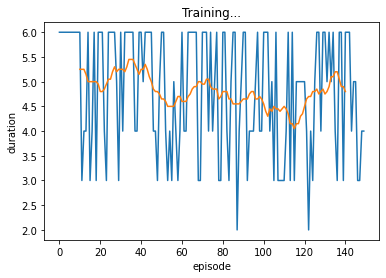

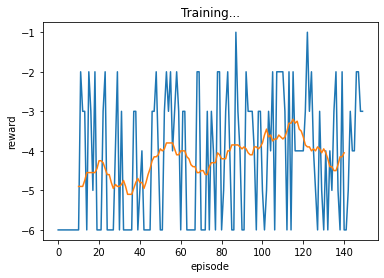

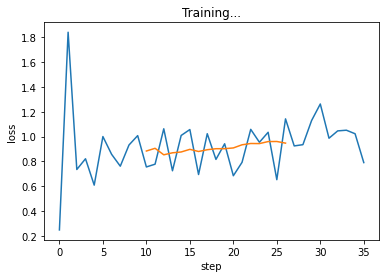

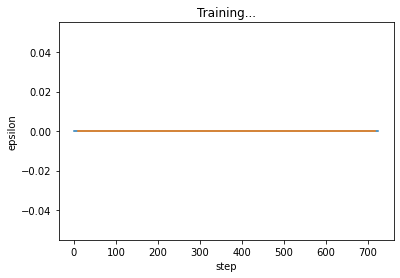

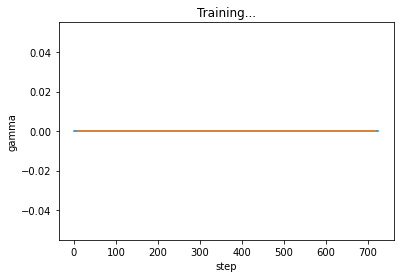

In [13]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=300,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))